In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mnist import load_mnist

train, validation, test = load_mnist()

X_train = train[0].reshape(-1, 28, 28)
y_train = train[1]

X_val = validation[0].reshape(-1, 28, 28)
y_val = validation[1]

X_test = test[0].reshape(-1, 28, 28)
y_test = test[1]


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


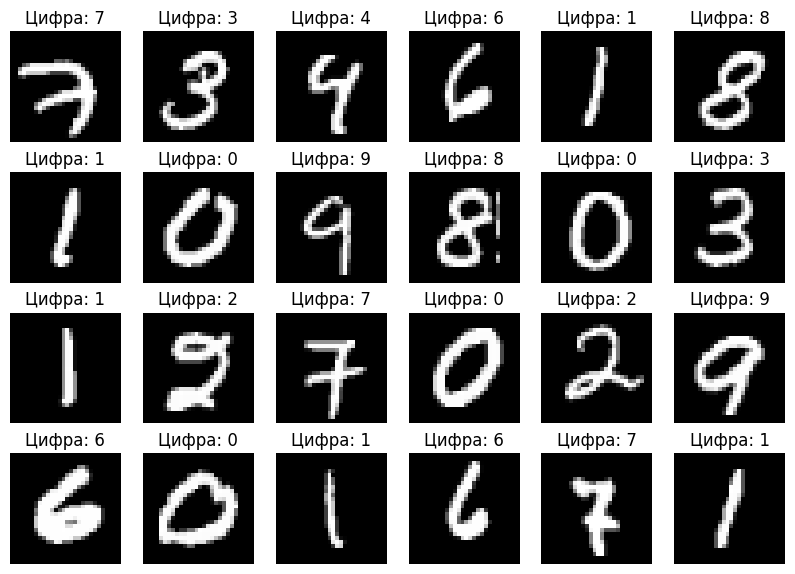

In [2]:
fig, axs = plt.subplots(4, 6, figsize=(10, 7))
for i in range(24):
    axs[i // 6, i % 6].imshow(X_train[i], cmap='gray')
    axs[i // 6, i % 6].set_title(f"Цифра: {y_train[i]}")
    axs[i // 6, i % 6].axis('off')
plt.show()


In [3]:
class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        Xc = X - self.mean_
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        self.components_ = Vt
        self.explained_variance_ = (S**2)/(X.shape[0]-1)
        return self

    def transform(self, X):
        Xc = X - self.mean_
        comps = self.components_[:self.n_components] if self.n_components else self.components_
        return Xc @ comps.T

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


In [4]:
class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        preds = []
        for x in X:
            d = np.linalg.norm(self.X - x, axis=1)
            idx = np.argsort(d)[:self.n_neighbors]
            vals, cnts = np.unique(self.y[idx], return_counts=True)
            preds.append(vals[np.argmax(cnts)])
        return np.array(preds)


In [5]:
X_flat = X_train.reshape(X_train.shape[0], -1)
y = y_train


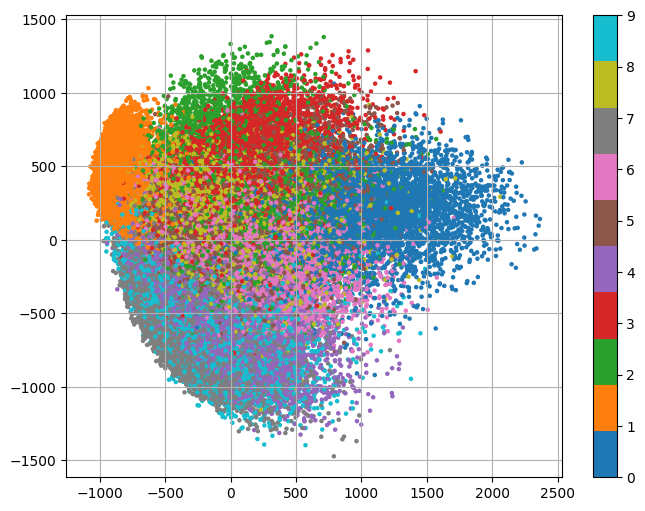

In [6]:
pca2 = my_PCA(n_components=2)
Xp = pca2.fit_transform(X_flat)

plt.figure(figsize=(8,6))
plt.scatter(Xp[:,0], Xp[:,1], c=y, cmap='tab10', s=5)
plt.colorbar()
plt.grid(True)
plt.show()


In [7]:
sample_size = 1000
idx = np.random.choice(len(X_flat), sample_size, replace=False)

X_s = X_flat[idx]
y_s = y[idx]

X_s = (X_s - X_s.mean(axis=0)) / (X_s.std(axis=0) + 1e-8)

X_tr, X_te, y_tr, y_te = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

knn = my_kNN(5)
knn.fit(X_tr, y_tr)
y_pred = knn.predict(X_te)

print("Accuracy без PCA:", accuracy_score(y_te, y_pred))


Accuracy без PCA: 0.825


In [8]:
print("Оптимизация параметров kNN с PCA...")

sample_size = 3000
indices = np.random.choice(len(X_flat), sample_size, replace=False)

X_sub = X_flat[indices]
y_sub = y[indices]

X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42
)

# -------------------------------
# СЕТКА ПАРАМЕТРОВ
# -------------------------------
n_components_list = [2, 5, 10, 15, 30]
n_neighbors_list = [1, 3, 5, 7, 10]

results = []
best_accuracy = 0.0
best_params = (n_components_list[0], n_neighbors_list[0])

# -------------------------------
# ПЕРЕБОР
# -------------------------------
for n_components in n_components_list:
    print(f"\nPCA: {n_components} компонент")

    pca = my_PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_opt)
    X_test_pca = pca.transform(X_test_opt)

    # Нормализация (ТОЛЬКО ПО TRAIN)
    mean = X_train_pca.mean(axis=0)
    std = X_train_pca.std(axis=0) + 1e-8
    X_train_pca = (X_train_pca - mean) / std
    X_test_pca = (X_test_pca - mean) / std

    for n_neighbors in n_neighbors_list:
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train_opt)

        y_pred = knn.predict(X_test_pca)
        acc = accuracy_score(y_test_opt, y_pred)

        results.append((n_components, n_neighbors, acc))

        if acc > best_accuracy:
            best_accuracy = acc
            best_params = (n_components, n_neighbors)

        print(f"  k={n_neighbors}: accuracy={acc:.4f}")

print("\nЛучшие параметры:")
print(f"PCA компоненты: {best_params[0]}")
print(f"kNN соседи: {best_params[1]}")
print(f"Лучшая точность: {best_accuracy:.4f}")


Оптимизация параметров kNN с PCA...

PCA: 2 компонент
  k=1: accuracy=0.3450
  k=3: accuracy=0.3850
  k=5: accuracy=0.4100
  k=7: accuracy=0.4333
  k=10: accuracy=0.4317

PCA: 5 компонент
  k=1: accuracy=0.6433
  k=3: accuracy=0.6667
  k=5: accuracy=0.6983
  k=7: accuracy=0.7100
  k=10: accuracy=0.6967

PCA: 10 компонент
  k=1: accuracy=0.8500
  k=3: accuracy=0.8700
  k=5: accuracy=0.8817
  k=7: accuracy=0.8783
  k=10: accuracy=0.8767

PCA: 15 компонент
  k=1: accuracy=0.9083
  k=3: accuracy=0.9083
  k=5: accuracy=0.9050
  k=7: accuracy=0.9117
  k=10: accuracy=0.9000

PCA: 30 компонент
  k=1: accuracy=0.9283
  k=3: accuracy=0.9183
  k=5: accuracy=0.9117
  k=7: accuracy=0.9217
  k=10: accuracy=0.9150

Лучшие параметры:
PCA компоненты: 30
kNN соседи: 1
Лучшая точность: 0.9283


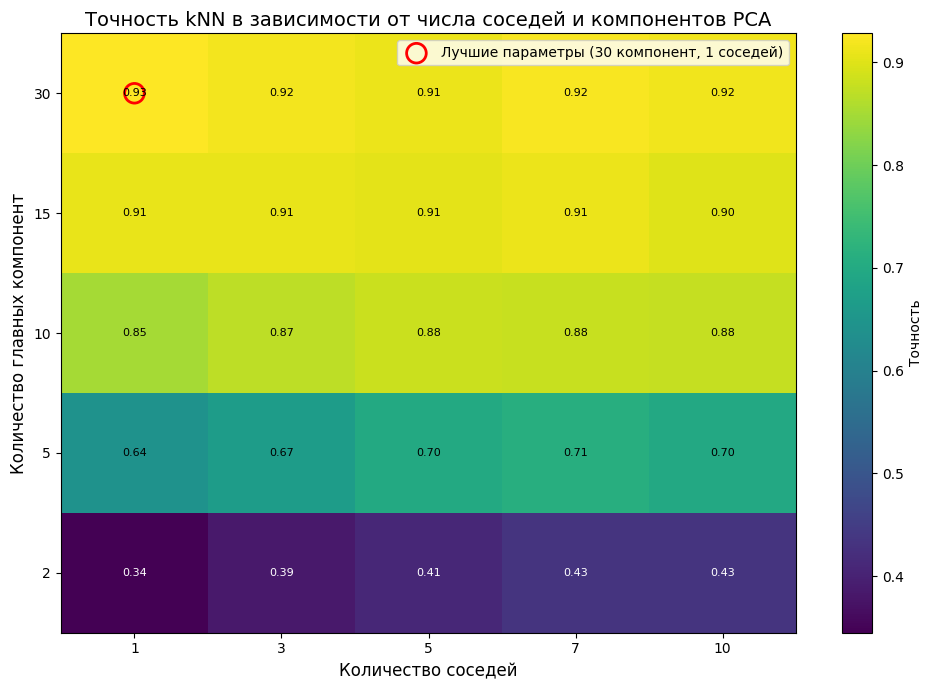

In [9]:
# Создаём матрицу
accuracy_matrix = np.zeros((len(n_components_list), len(n_neighbors_list)))
for comp, neigh, acc in results:
    i = n_components_list.index(comp)
    j = n_neighbors_list.index(neigh)
    accuracy_matrix[i, j] = acc

# Тепловая карта
plt.figure(figsize=(10, 7))
plt.imshow(accuracy_matrix, origin='lower', cmap='viridis', aspect='auto')

#  оси их настройка
plt.xticks(range(len(n_neighbors_list)), n_neighbors_list)
plt.yticks(range(len(n_components_list)), n_components_list)
plt.xlabel('Количество соседей', fontsize=12)
plt.ylabel('Количество главных компонент', fontsize=12)
plt.title('Точность kNN в зависимости от числа соседей и компонентов PCA', fontsize=14)

# Цветовая шкала
cbar = plt.colorbar(label='Точность')

# Аннотации значений точности
for i in range(len(n_components_list)):
    for j in range(len(n_neighbors_list)):
        plt.text(j, i, f"{accuracy_matrix[i, j]:.2f}",
                 ha='center', va='center',
                 color='white' if accuracy_matrix[i,j]<0.6 else 'black', fontsize=8)

#  параметры
best_comp_idx = n_components_list.index(best_params[0])
best_neigh_idx = n_neighbors_list.index(best_params[1])
plt.scatter(best_neigh_idx, best_comp_idx, s=200, marker='o',
            facecolor='none', edgecolor='red', linewidth=2,
            label=f'Лучшие параметры ({best_params[0]} компонент, {best_params[1]} соседей)')

plt.legend(loc='upper right', fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()



In [10]:

# PCA для оценки дисперсии
pca_full = my_PCA()
pca_full.fit(X_flat)

cumulative_variance = np.cumsum(pca_full.explained_variance_) / np.sum(pca_full.explained_variance_)
first_15_variance = cumulative_variance[14]

print("=" * 60)
print("РЕЗУЛЬТАТЫ")
print("=" * 60)

print(f"Доля дисперсии первых 15 компонент: {first_15_variance:.4f} ({first_15_variance*100:.2f}%)")
print("Линейная разделимость в 2D PCA: слабая, классы пересекаются")

# Безопасный вывод accuracy_orig
if 'accuracy_orig' in globals():
    print(f"\nkNN без PCA: {accuracy_orig:.4f}")
else:
    print("\nkNN без PCA: не вычислялось")

# Безопасный вывод best_accuracy
if 'best_accuracy' in globals():
    print(f"kNN + PCA: {best_accuracy:.4f}")
else:
    print("kNN + PCA: не вычислялось")

# Безопасный вывод best_params
if 'best_params' in globals():
    print(f"Лучшие параметры: PCA={best_params[0]}, k={best_params[1]}")
else:
    print("Лучшие параметры: не определены")

print("=" * 60)



РЕЗУЛЬТАТЫ
Доля дисперсии первых 15 компонент: 0.5791 (57.91%)
Линейная разделимость в 2D PCA: слабая, классы пересекаются

kNN без PCA: не вычислялось
kNN + PCA: 0.9283
Лучшие параметры: PCA=30, k=1
